In [41]:
from data_querier import DataQuerierYF
from config import load_config
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import pandas as pd
import bahc

In [1]:
configuration = load_config()
data_getter = DataQuerierYF(configuration)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [194]:
from portfolios.markowitz import MarkowitzPortfolio
from config import load_config
import pandas as pd

configuration = load_config()
portfolio = MarkowitzPortfolio(configuration)
portfolio.data

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.816809,4.826837,66.431740,12.591938,NaN,32.449615,18.250000,22.094469,43.607437,28.570000,...,19.697954,26.523657,57.094894,33.148170,21.926783,34.782372,49.557648,35.720001,14.441824,NaN
2012-01-04,23.627478,4.741990,67.989159,12.659610,NaN,32.560432,18.110001,22.008772,43.590973,28.280001,...,19.568268,26.245665,57.108143,33.138798,22.650698,35.019894,48.886967,35.450001,14.760459,NaN
2012-01-05,24.156307,5.156795,68.421791,12.800155,NaN,32.807610,18.270000,21.958132,42.759167,28.480000,...,19.654726,26.474594,56.935543,33.166908,22.327991,35.287136,49.465786,35.400002,15.173819,NaN
2012-01-06,24.417461,5.279352,68.739059,12.933966,NaN,32.892834,18.139999,21.759470,42.685055,28.719999,...,19.597090,26.302891,56.510658,32.970150,21.952944,35.542500,49.594406,35.110001,15.191044,NaN
2012-01-09,25.057272,5.392481,68.719826,12.913449,NaN,32.875793,18.209999,21.755573,42.610928,28.530001,...,19.611498,26.875231,56.762924,32.810863,22.040165,35.405922,49.961906,34.950001,15.397719,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.531204,18.170000,236.500000,180.330002,133.029587,131.899994,357.829987,140.962799,414.255981,577.679993,...,66.820000,222.779999,61.889999,55.841362,118.290001,138.009995,127.809998,606.330017,63.009998,246.114746
2021-12-28,158.970612,18.540001,238.130005,179.289993,133.009781,132.360001,357.440002,139.976273,414.196136,569.359985,...,67.620003,220.270004,61.689999,55.921204,119.519997,137.979996,128.210007,597.320007,63.110001,243.858383
2021-12-29,160.438675,18.049999,241.029999,179.380005,133.969818,133.339996,361.839996,140.693741,414.345795,569.289978,...,67.959999,217.619995,61.150002,56.540001,119.360001,138.660004,128.229996,601.119995,63.450001,246.633926


### Cleaning Data

In [195]:
def clean_portfolio(portfolio):
    portfolio.data.fillna(method = 'ffill', inplace = True)
    columns_missing = portfolio.data.columns[portfolio.data.isna().sum() > 10].values
    portfolio.data.drop(columns_missing, inplace= True, axis=1)
    portfolio.data.fillna(method = 'bfill', inplace = True)
    return portfolio

In [196]:
portfolio = clean_portfolio(portfolio)
portfolio.data.shape

(2517, 457)

In [197]:
def get_log_returns_matrix(portfolio_data):
    # returns_matrix = portfolio_data.pct_change()
    log_returns_matrix = np.log(portfolio_data/portfolio_data.shift(1))
    log_returns_matrix.fillna(0, inplace=True)
    log_returns_matrix = log_returns_matrix[(log_returns_matrix.T != 0).any()]
    return log_returns_matrix

In [198]:
portfolio_data = portfolio.data.iloc[:, :50]
log_returns_matrix = get_log_returns_matrix(portfolio_data)
log_returns_matrix.shape

(2516, 50)

### Unfiltered Covariance Matrix

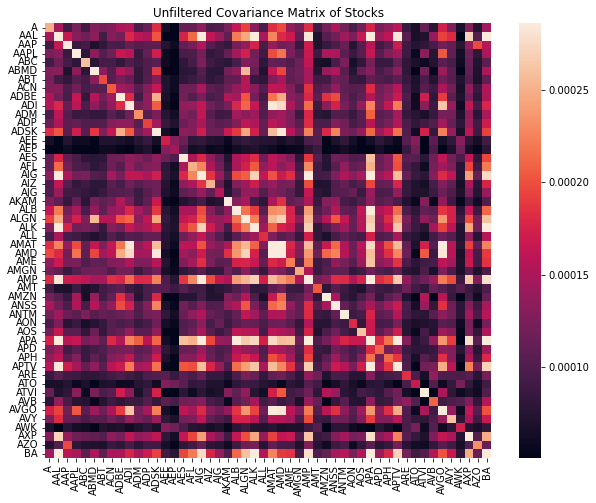

In [199]:
import seaborn as sns
cov_daily = log_returns_matrix.cov()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cov_daily, 
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("Unfiltered Covariance Matrix of Stocks")
plt.show()

### Hierarchical Clustering of Stocks

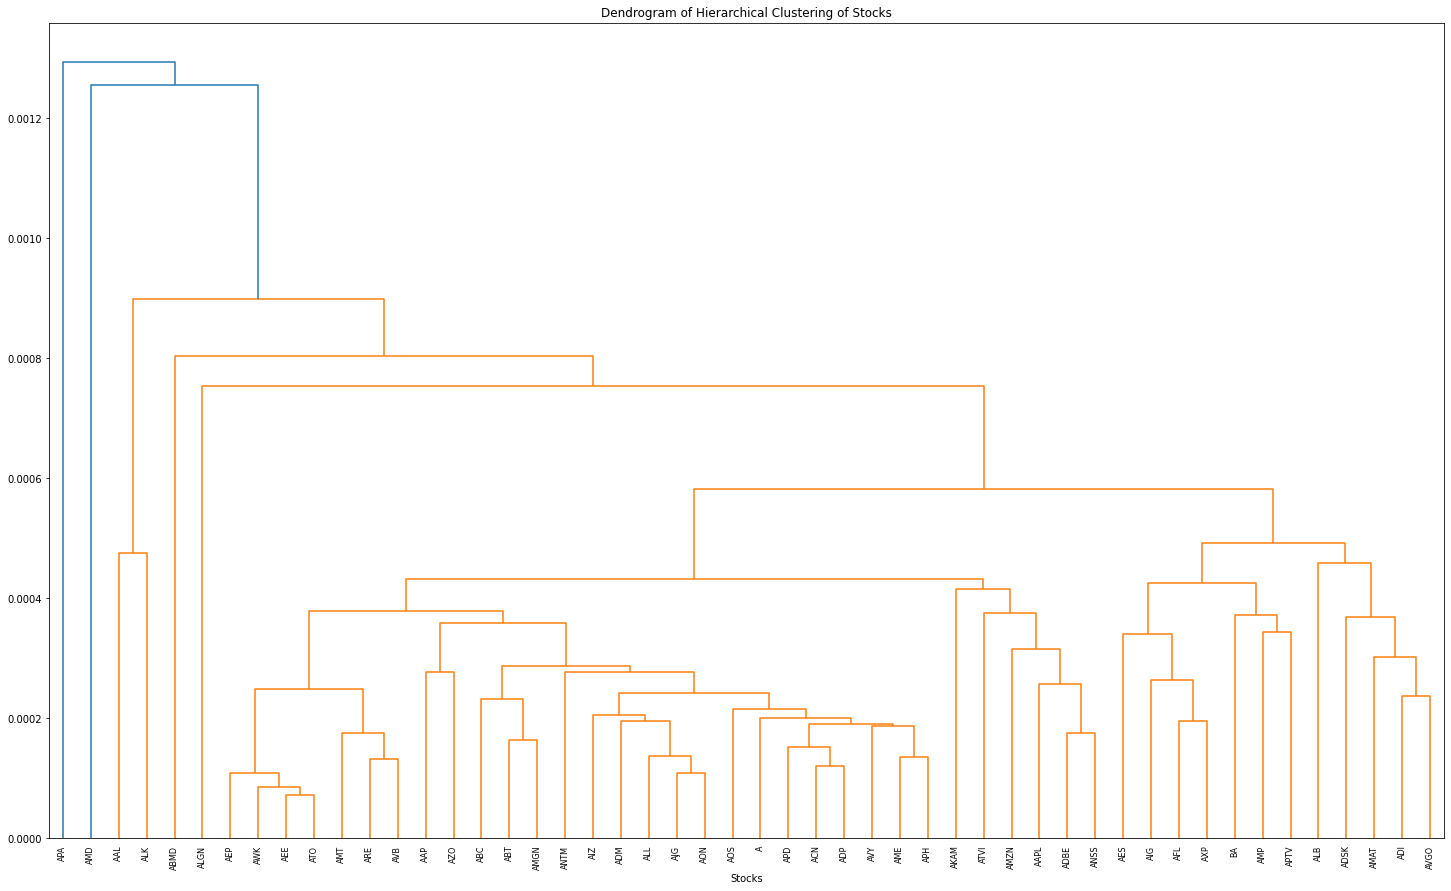

In [200]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

stocks = list(cov_daily.columns)
link = linkage(cov_daily, 'average')
fig = plt.subplots(figsize=(25,15))
d = dendrogram(link, labels = stocks)
plt.title('Dendrogram of Hierarchical Clustering of Stocks')
plt.xlabel('Stocks')
plt.show()

In [ ]:
def get_stocks_reordered(log_returns_matrix):
    cov_daily = log_returns_matrix.cov()
    stocks = list(cov_daily.columns)
    link = linkage(cov_daily, 'average')
    reordered_cov_daily = cov_daily.copy()
    stocks_reordered = [stocks[i] for i in leaves_list(link)]
    reordered_cov_daily = reordered_cov_daily[stocks_reordered]
    reordered_cov_daily = reordered_cov_daily.reindex(stocks_reordered)
    return stocks_reordered, reordered_cov_daily

In [202]:
stocks_reordered, reordered_cov_daily = get_stocks_reordered(log_returns_matrix)
print(stocks_reordered)

['APA', 'AMD', 'AAL', 'ALK', 'ABMD', 'ALGN', 'AEP', 'AWK', 'AEE', 'ATO', 'AMT', 'ARE', 'AVB', 'AAP', 'AZO', 'ABC', 'ABT', 'AMGN', 'ANTM', 'AIZ', 'ADM', 'ALL', 'AJG', 'AON', 'AOS', 'A', 'APD', 'ACN', 'ADP', 'AVY', 'AME', 'APH', 'AKAM', 'ATVI', 'AMZN', 'AAPL', 'ADBE', 'ANSS', 'AES', 'AIG', 'AFL', 'AXP', 'BA', 'AMP', 'APTV', 'ALB', 'ADSK', 'AMAT', 'ADI', 'AVGO']


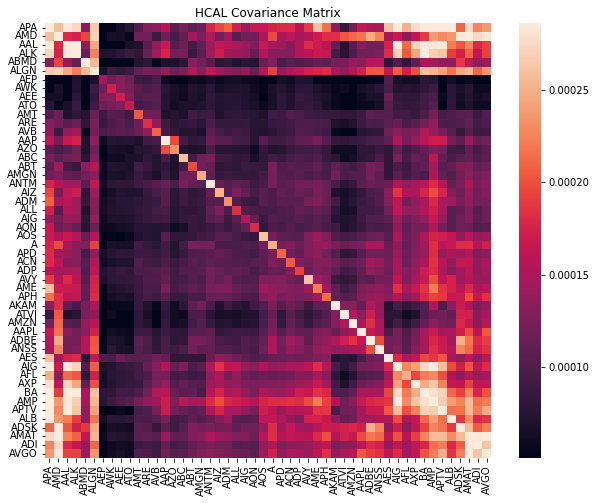

In [203]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(reordered_cov_daily, 
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("HCAL Covariance Matrix")
plt.show()

### Filtered Covariance Matrix with BAHC

In [204]:
def get_bahc_cov_matrix(log_returns_matrix, stocks_reordered):
    cov_bahc = pd.DataFrame(bahc.filterCovariance(np.array(log_returns_matrix).T))
    cov_bahc.columns, cov_bahc.index = log_returns_matrix.columns, log_returns_matrix.columns
    cov_bahc = cov_bahc[stocks_reordered]
    cov_bahc = cov_bahc.reindex(stocks_reordered)
    return cov_bahc

In [205]:
get_bahc_cov_matrix(log_returns_matrix, stocks_reordered).head()

,APA,AMD,AAL,ALK,ABMD,ALGN,AEP,AWK,AEE,ATO,...,AFL,AXP,BA,AMP,APTV,ALB,ADSK,AMAT,ADI,AVGO
APA,0.001275,0.000335,0.000356,0.000273,0.000215,0.000309,0.000134,0.000145,0.000145,0.000142,...,0.000184,0.000207,0.000269,0.000239,0.000263,0.000267,0.000256,0.000261,0.000208,0.000252
AMD,0.000335,0.001284,0.000298,0.000229,0.000215,0.000254,0.000115,0.000124,0.000124,0.000122,...,0.000150,0.000168,0.000218,0.000194,0.000213,0.000213,0.000208,0.000212,0.000169,0.000205
AAL,0.000356,0.000298,0.000989,0.000530,0.000190,0.000302,0.000126,0.000136,0.000136,0.000134,...,0.000186,0.000210,0.000305,0.000241,0.000265,0.000259,0.000254,0.000258,0.000206,0.000250
ALK,0.000273,0.000229,0.000530,0.000582,0.000146,0.000232,0.000097,0.000104,0.000105,0.000103,...,0.000143,0.000161,0.000234,0.000185,0.000203,0.000199,0.000195,0.000198,0.000158,0.000192
ABMD,0.000215,0.000215,0.000190,0.000146,0.000803,0.000164,0.000073,0.000079,0.000079,0.000078,...,0.000095,0.000107,0.000139,0.000124,0.000136,0.000136,0.000132,0.000135,0.000108,0.000131


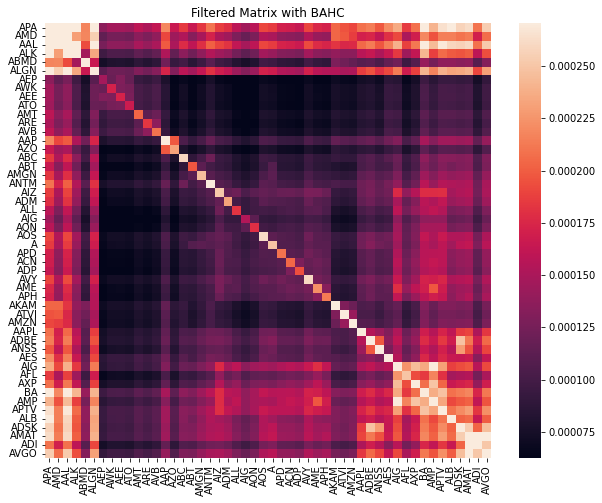

In [206]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cov_bahc,
            xticklabels=True, 
            yticklabels=True,
            robust=True)
plt.title("Filtered Matrix with BAHC")
plt.show()

### Building the Mean Variance Portfolio

In [207]:
def get_covariance_matrix(portfolio):
    cov_matrix = get_expected_return(portfolio).cov()
    return cov_matrix

In [208]:
def min_var_portfolio(mu, cov, target_return):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(len(mu))[:, np.newaxis]
    
    a = ones.T @ inv_cov @ ones
    b = mu.T @ inv_cov @ ones
    c = mu.T.to_numpy() @ inv_cov @ mu
    
    a = a[0][0]
    b = b.loc['mu', 0]
    c = c.loc[0, 'mu']
    
    num1 = (a * inv_cov @ mu - b * inv_cov @ ones) * target_return
    num2 = (c * inv_cov @ ones- b * inv_cov @ mu)
    den = a*c - b**2
    
    w = (num1 + num2) / den
    
    var = w.T.to_numpy() @ cov.to_numpy() @ w.to_numpy()
    return w, var**0.5

In [209]:
def portfolio_variance(cov, w):
    return w.T @ cov @ w

In [210]:
def inverse_sharpe(w, mu_vector, cov_matrix, rf):
    excess_return = w.T @ mu_vector - rf
    std_dev = (w.T @ cov_matrix @ w)**0.5

In [211]:
def get_weights(mu_vector, cov_matrix, rf):
    ones = np.ones(mu_vector.shape[0])[:, np.newaxis]
    num = np.linalg.inv(cov_matrix) @ (mu_vector - rf * ones)
    den = ones.T @ np.linalg.inv(cov_matrix) @ (mu_vector - rf * ones)
    w = (np.asarray(num) / np.asarray(den))
    weights = pd.DataFrame(index = mu_vector.index, columns = ['Weights'])
    weights['Weights'] = w
    return w, weights

In [212]:
def build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = False, plot_bool = False):
    training_period = 10
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    log_returns_matrix = get_log_returns_matrix(portfolio_data)
    
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])
    
    if bahc_bool == False:
        cov_matrix = log_returns_matrix.cov() * 252
    else:
        stocks_reordered, _ = get_stocks_reordered(log_returns_matrix)
        cov_matrix = get_bahc_cov_matrix(log_returns_matrix, stocks_reordered) * 252
    
    for stock in stocks_universe:
        series = portfolio_data[stock]
        log_returns = np.log(series/series.shift(1)).dropna()
        ann_log_return = np.sum(log_returns) / training_period
        mu_vector.loc[stock] = ann_log_return
        
    annualized_returns = log_returns_matrix.sum() / training_period
    annualized_variance = log_returns_matrix.var() * 252

    mean_variance_stocks = pd.DataFrame(index = annualized_returns.index)
    mean_variance_stocks['mu'] = annualized_returns
    mean_variance_stocks['sigma'] = np.sqrt(annualized_variance)

    ranked_positive_returns = [i for i in annualized_returns if i > 0]
    ranked_positive_returns.sort()
    
    lo_bound_return = ranked_positive_returns[0]
    hi_bound_return = ranked_positive_returns[-1] + 1.5
    mean_variance_port = pd.DataFrame(columns = ['var'], 
                                      index = np.arange(lo_bound_return, hi_bound_return, (hi_bound_return - lo_bound_return)/20))
    for i in mean_variance_port.index:
        w_min_var, var = min_var_portfolio(mu_vector, cov_matrix, i)
        mean_variance_port.loc[i] = var
        
    w_tangency, weights_tangency = get_weights(mu_vector, cov_matrix, rf)
    cap_allocation_line = pd.DataFrame(columns = ['mu'], index = np.arange(0,0.9,0.05))
    exp_ret = (w_tangency.T @ mu_vector).iloc[0,0]
    exp_vol = np.sqrt((w_tangency.T @ cov_matrix @ w_tangency).iloc[0,0])
    tangency_port = (exp_ret, exp_vol) 

    cal_slope = (exp_ret - rf) / exp_vol
    for i in cap_allocation_line.index:
        cap_allocation_line.loc[i] = rf + i*cal_slope

    if plot_bool:
        plot_efficient_frontier(mean_variance_port, cap_allocation_line, mean_variance_stocks, tangency_port)

    return w_tangency, weights_tangency, w_min_var, log_returns_matrix, tangency_port, mean_variance_port, mean_variance_stocks

In [213]:
def plot_efficient_frontier(mean_variance_port, cap_allocation_line, mean_variance_stocks, tangency_port):
    plt.figure(figsize=(12,8))
    plt.plot(mean_variance_port['var']*100, 
             mean_variance_port.index*100, 
             label = 'Efficient Frontier')
    plt.plot(cap_allocation_line.index*100, 
             cap_allocation_line['mu']*100, 
             label = 'Capital Allocation Line', 
             linestyle = 'dashed', 
             linewidth = 1)
    plt.scatter(mean_variance_stocks['sigma']*100, 
                mean_variance_stocks['mu']*100,
                s=2, 
                c='r', 
                marker='x', 
                label = 'Individual Stocks')
    plt.scatter(tangency_port[1]*100, 
                tangency_port[0]*100, 
                label = 'Tangency portfolio', 
                marker = 'x')
    plt.title('Efficient frontier')
    plt.xlabel('Annualized Standard Deviation (%)')
    plt.ylabel('Annualized Return (%)')
    plt.legend()
    plt.show()

### Cumulative Returns of Tangency Portfolio using Unfiltered Covariance Matrix

In [214]:
def get_cumulative_returns(w, log_returns_matrix):
    weighted_returns = (w.T * log_returns_matrix)
    portfolio_returns = weighted_returns.sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    return cumulative_returns

In [215]:
def plot_cumulative_returns(cumulative_returns):
    fig = plt.figure()
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
    ax1.plot(cumulative_returns)
    ax1.set_xlabel('Date')
    ax1.set_ylabel("Cumulative Returns")
    ax1.set_title("Portfolio Cumulative Returns")
    plt.show()

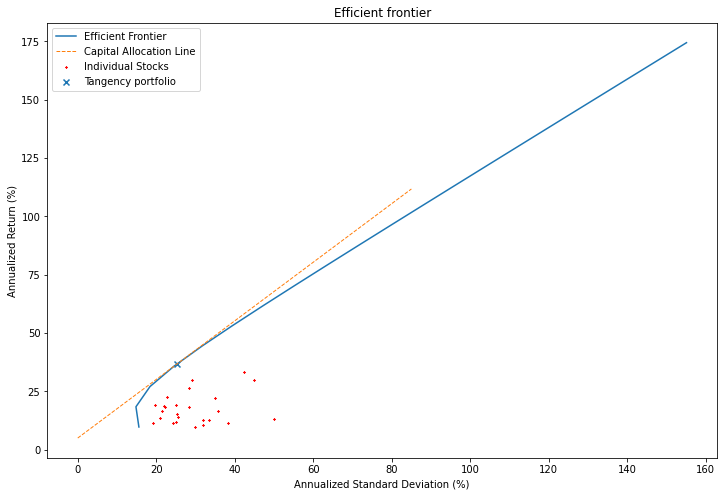

In [216]:
w_tangency, weights_tangency, w_min_var, log_returns_matrix, tangency_port, mean_variance_port, mean_variance_stocks = build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = False, plot_bool = True)

In [217]:
print('Tangent Portfolio Unfiltered Covariance Matrix: Expected Return of {:f} and Volatility of {:f}'.format(tangency_port[0], tangency_port[1]))

Tangent Portfolio Unfiltered Covariance Matrix: Expected Return of 0.369112 and Volatility of 0.254093


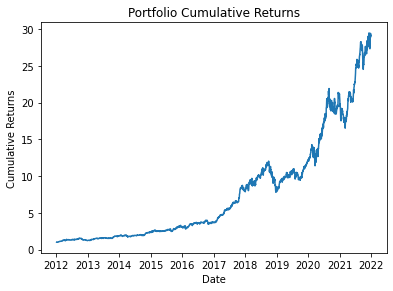

In [179]:
cumulative_returns_tangent = get_cumulative_returns(w_tangency, log_returns_matrix)
plot_cumulative_returns(cumulative_returns_tangent)

In [218]:
weights_tangency.T

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL
Weights,-0.034345,0.037226,-0.011546,0.264542,0.006073,0.107414,-0.047543,0.460107,0.413265,-0.127667,...,-0.230518,-0.185572,-0.26042,0.089314,0.480048,-0.168706,-0.001313,0.173364,-0.091512,0.251001


### Cumulative Returns of Tangency Portfolio using BAHC-Filtered Covariance Matrix

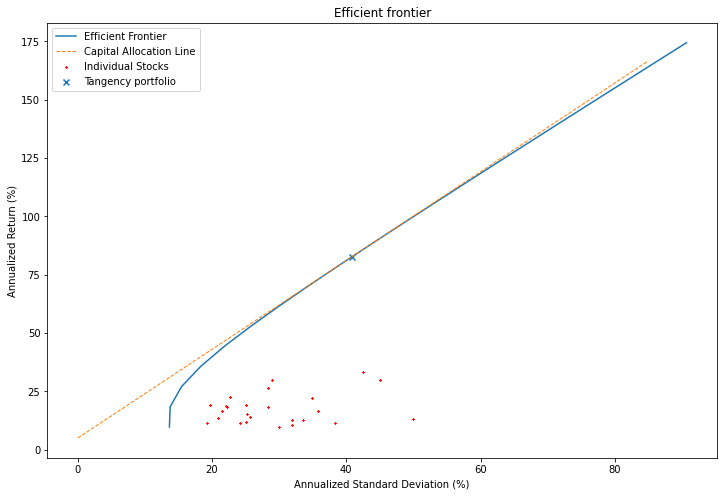

In [220]:
w_tangency_bahc, _, _, log_returns_matrix_bahc, tangency_port_bahc, _, _ = build_frontier(portfolio, rf = 0.05, num_assets = 25, bahc_bool = True, plot_bool = True)

In [221]:
print('Tangent Portfolio BAHC-Filtered Covariance Matrix: Expected Return of {:f} and Volatility of {:f}'.format(tangency_port_bahc[0], tangency_port_bahc[1]))

Tangent Portfolio BAHC-Filtered Covariance Matrix: Expected Return of 0.826155 and Volatility of 0.408100


### Tangency Portfolio without Rolling Window

In [268]:
def get_tangency_portfolio(portfolio, rf = 0.05, num_assets = 25, bahc_bool = False):
    training_period = 10
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    log_returns_matrix = get_log_returns_matrix(portfolio_data)
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])

    if bahc_bool == False:
        cov_matrix = log_returns_matrix.cov() * 252
    else:
        stocks_reordered, _ = get_stocks_reordered(log_returns_matrix)
        cov_matrix = get_bahc_cov_matrix(log_returns_matrix, stocks_reordered) * 252

    for stock in stocks_universe:
        series = portfolio_data[stock]
        log_returns = np.log(series/series.shift(1)).dropna()
        ann_log_return = np.sum(log_returns) / training_period
        mu_vector.loc[stock] = ann_log_return

    w_tangency, _ = get_weights(mu_vector, cov_matrix, rf)
    cumulative_returns_tangent = get_cumulative_returns(w_tangency, log_returns_matrix)

    return cumulative_returns_tangent

#### Cumulative Returns of Tangency Portfolio without Rolling and BAHC-Filtered Covariance Matrix

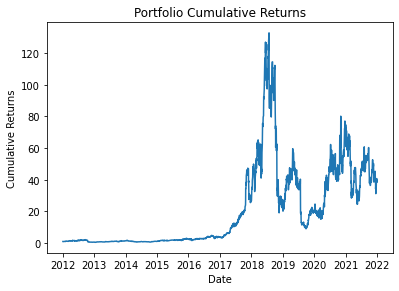

In [275]:
cumulative_returns_tangent_bahc = get_tangency_portfolio(portfolio, bahc_bool = True)
plot_cumulative_returns(cumulative_returns_tangent_bahc)

#### Cumulative Returns of Tangency Portfolio without Rolling and Unfiltered Covariance Matrix

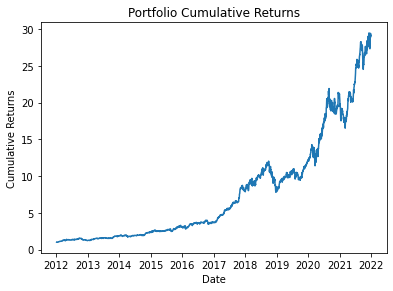

In [276]:
cumulative_returns_tangent = get_tangency_portfolio(portfolio, bahc_bool = False)
plot_cumulative_returns(cumulative_returns_tangent)

#### Comparison of Filtered vs Unfiltered without Rolling Window Tangency Portfolio

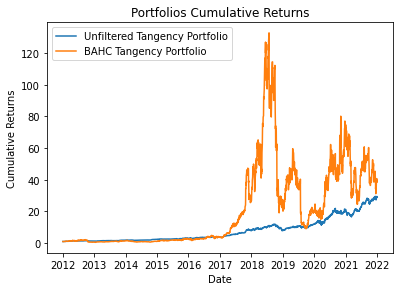

In [277]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_returns_tangent, label = 'Unfiltered Tangency Portfolio')
ax1.plot(cumulative_returns_tangent_bahc, label = 'BAHC Tangency Portfolio')
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Tangency Portfolios witout Rolling Window Cumulative Returns")
plt.legend()
plt.show()

### Tangency Portfolio with Rolling Window

In [278]:
def get_rolling_tangency_portfolio(portfolio, window = 90, rf = 0.05, num_assets = 25, step = 1, bahc_bool = False):
    training_period = 10
    portfolio = clean_portfolio(portfolio)
    portfolio_data = portfolio.data.iloc[:, :num_assets]
    stocks_universe = portfolio_data.columns
    
    log_returns_matrix = get_log_returns_matrix(portfolio_data)
    mu_vector = pd.DataFrame(index = stocks_universe, columns = ['mu'])
    
    portfolio_returns = pd.Series([0] * window, index = log_returns_matrix.index[0:window])
    for i in range(0, len(log_returns_matrix) - window, step):
        window_log_returns_matrix = log_returns_matrix[i: i+window].copy()
        next_log_returns_matrix = log_returns_matrix[i+window: i+window+step].copy()
        if bahc_bool == False:
            cov_matrix = log_returns_matrix.cov() * 252
        else:
            stocks_reordered, _ = get_stocks_reordered(window_log_returns_matrix)
            cov_matrix = get_bahc_cov_matrix(window_log_returns_matrix, stocks_reordered) * 252

        for stock in stocks_universe:
            series = portfolio_data[stock]
            log_returns = np.log(series/series.shift(1)).dropna()
            ann_log_return = np.sum(log_returns) / training_period
            mu_vector.loc[stock] = ann_log_return

        w_tangency, _ = get_weights(mu_vector, cov_matrix, rf)
        portfolio_returns = pd.concat([portfolio_returns, next_log_returns_matrix.apply(lambda x: w_tangency.T @ x, axis = 1)])
        cumulative_returns = (portfolio_returns_tangency + 1).cumprod()
        
    return cumulative_returns

#### Cumulative Returns of Tangency Portfolio with Rolling Window of 90 days and BAHC-Filtered Covariance Matrix

In [ ]:
window_cumulative_returns_tangency_bahc = get_rolling_tangency_portfolio(portfolio, bahc_bool = True)
plot_cumulative_returns(window_cumulative_returns_tangency_bahc)

#### Cumulative Returns of Tangency Portfolio with Rolling Window of 90 days and Unfiltered Covariance Matrix

In [ ]:
window_cumulative_returns_tangency = get_rolling_tangency_portfolio(portfolio, bahc_bool = True)
plot_cumulative_returns(window_cumulative_returns_tangency)

#### Comparison Tangency Portfolio of BAHC vs Unfiltered with Rolling Window of 90 days

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(window_cumulative_returns_tangent, label = 'Unfiltered Tangency Portfolio')
ax1.plot(window_cumulative_returns_tangent_bahc, label = 'BAHC Tangency Portfolio')
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Tangency Portfolios witout Rolling Window Cumulative Returns")
plt.legend()
plt.show()